# Pre-processing

In [9]:
import cv2
import os
import numpy as np
from tqdm import tqdm

def load_and_preprocess_data(base_dir, image_size=(128, 128)):
    X = []
    y = []

    labels = {'Male': 0, 'Female': 1}

    # Dùng Haar cascade để phát hiện khuôn mặt
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    for label_name in ['Male', 'Female']:
        folder = os.path.join(base_dir, label_name)
        label = labels[label_name]

        for filename in tqdm(os.listdir(folder), desc=f"Processing {label_name}"):
            path = os.path.join(folder, filename)

            img = cv2.imread(path)
            if img is None:
                continue  # Bỏ ảnh lỗi

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)

            if len(faces) == 0:
                continue

            # Chọn khuôn mặt lớn nhất
            (x, y_top, w, h) = sorted(faces, key=lambda b: b[2]*b[3], reverse=True)[0]
            face = gray[y_top:y_top+h, x:x+w]
            face_resized = cv2.resize(face, image_size)
            face_normalized = face_resized / 255.0

            X.append(face_normalized)
            y.append(label)

    X = np.array(X).reshape(-1, image_size[0], image_size[1], 1)
    y = np.array(y)

    return X, y


In [10]:
X, y = load_and_preprocess_data('/Users/softann/Documents/genderclassification/Training')
print("Shape ảnh:", X.shape)
print("Shape nhãn:", y.shape)


Processing Female: 100%|██████████| 23243/23243 [00:34<00:00, 676.51it/s]


Shape ảnh: (13904, 128, 128, 1)
Shape nhãn: (13904,)


<Figure size 1000x500 with 0 Axes>

/var/folders/mn/zctw1zfj6l914xbp3t_jry2w0000gn/T/ipykernel_3875/1809968785.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='Set2')


<Axes: ylabel='count'>

([<matplotlib.axis.XTick at 0x134bd3b90>,
 [Text(0, 0, 'Male'), Text(1, 0, 'Female')])

Text(0.5, 1.0, 'Distribution of Genders')

Text(0.5, 0, 'Gender')

Text(0, 0.5, 'Count')

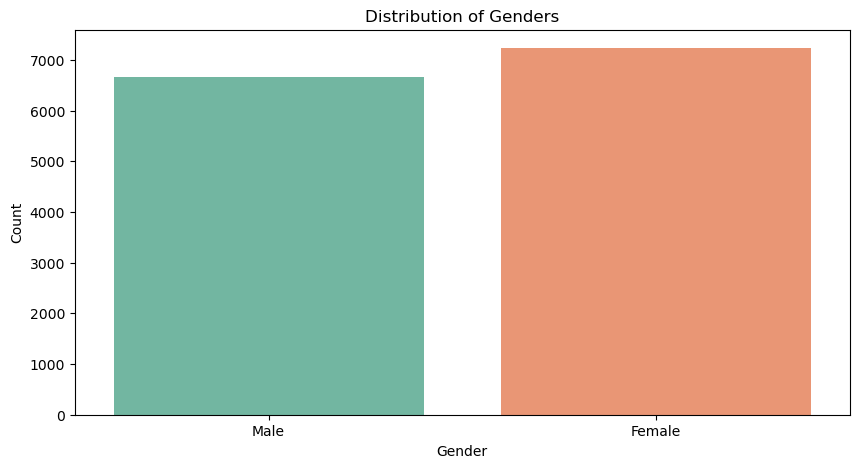

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.countplot(x=y, palette='Set2')
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])  # Sửa dấu nháy bị lỗi và thiếu
plt.title('Distribution of Genders')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


In [12]:
from sklearn.model_selection import train_test_split

# Giả sử X, y đã được tạo từ hàm tiền xử lý
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Nếu dùng mô hình học máy cổ điển: flatten ảnh
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

<Figure size 600x400 with 0 Axes>

/var/folders/mn/zctw1zfj6l914xbp3t_jry2w0000gn/T/ipykernel_3875/599673112.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, palette='Set2')


<Axes: ylabel='count'>

([<matplotlib.axis.XTick at 0x1354fc890>,
 [Text(0, 0, 'Male'), Text(1, 0, 'Female')])

Text(0.5, 1.0, 'Test Set Gender Distribution')

Text(0.5, 0, 'Gender')

Text(0, 0.5, 'Count')

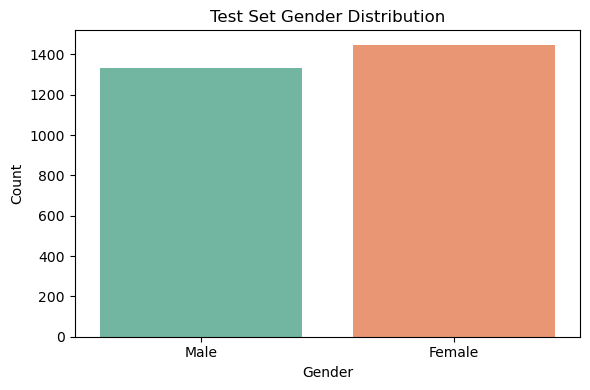

In [18]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_test, palette='Set2')
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])
plt.title('Test Set Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Huấn luyện mô hình

In [14]:
import time
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def train_and_compare_models(X_train, X_test, y_train, y_test):
    results = []

    models = [
        ("Logistic Regression", LogisticRegression(max_iter=1000)),
        ("KNN", KNeighborsClassifier(n_neighbors=5)),
        ("Decision Tree", DecisionTreeClassifier(max_depth=5)),
    ]

    for name, model in models:
        print(f"\n🔷 {name}")
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])
        start = time.time()
        pipeline.fit(X_train_flat, y_train)
        y_pred = pipeline.predict(X_test_flat)
        acc = accuracy_score(y_test, y_pred)
        duration = time.time() - start
        print(f"Accuracy: {acc:.4f}")
        print(f"Training time: {duration:.2f} s")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        results.append((name, acc, duration))

    # CNN part
    print("\n🔷 Convolutional Neural Network (CNN)")
    start = time.time()
    model_cnn = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32, verbose=1)
    loss, acc = model_cnn.evaluate(X_test, y_test, verbose=0)
    duration = time.time() - start
    print(f"Accuracy: {acc:.4f}")
    print(f"Training time: {duration:.2f} s")

    y_pred_prob = model_cnn.predict(X_test)
    y_pred_cnn = (y_pred_prob > 0.5).astype(int)
    print("Classification Report:")
    print(classification_report(y_test, y_pred_cnn))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_cnn))

    results.append(("CNN", acc, duration))



In [11]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [15]:
train_and_compare_models(X_train, X_test, y_train, y_test)


🔷 Logistic Regression


/Users/softann/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8324
Training time: 377.70 s
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1334
           1       0.83      0.85      0.84      1447

    accuracy                           0.83      2781
   macro avg       0.83      0.83      0.83      2781
weighted avg       0.83      0.83      0.83      2781

Confusion Matrix:
[[1088  246]
 [ 220 1227]]

🔷 KNN
Accuracy: 0.8749
Training time: 8.49 s
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1334
           1       0.90      0.85      0.88      1447

    accuracy                           0.87      2781
   macro avg       0.88      0.88      0.87      2781
weighted avg       0.88      0.87      0.87      2781

Confusion Matrix:
[[1201  133]
 [ 215 1232]]

🔷 Decision Tree
Accuracy: 0.7422
Training time: 43.35 s
Classification Report:
              precision    recall  f1-score

/Users/softann/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 46s 132ms/step - accuracy: 0.7143 - loss: 0.5605 - val_accuracy: 0.8990 - val_loss: 0.2527
Epoch 2/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 46s 131ms/step - accuracy: 0.9017 - loss: 0.2524 - val_accuracy: 0.9184 - val_loss: 0.2110
Epoch 3/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 44s 127ms/step - accuracy: 0.9326 - loss: 0.1845 - val_accuracy: 0.9385 - val_loss: 0.1760
Epoch 4/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 43s 125ms/step - accuracy: 0.9437 - loss: 0.1533 - val_accuracy: 0.9439 - val_loss: 0.1647
Epoch 5/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 44s 126ms/step - accuracy: 0.9550 - loss: 0.1299 - val_accuracy: 0.9428 - val_loss: 0.1628
Accuracy: 0.9428
Training time: 226.69 s
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1334
           1       0.94      0.95      0.95      1447

    accuracy                           0.94      2781
   macro avg       0.94     

In [16]:
# Lưu mô hình CNN
model_cnn.save

<bound method Model.save of <Sequential name=sequential, built=True>>